# Time Series Analysis Using full PSU dataset

In [1]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    #df_date['Start_Month'] = pd.to_datetime(df_date['Year'] + df_date['Start_Date'], format='%Y%b')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    #df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    #df_date = df_date.set_index(pd.DatetimeIndex(df_date['Term_Date']))
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl


def grouped_plot_graph(df_in):
    fig, ax = plt.subplots()
    grouped = df_in.groupby(['Year', 'Quarter'])
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Start_Month', y='Cap_Diff', label=key)
    plt.show()
    
def plot_graph(x_vals, y_vals):
    """
    Plots the dataframe information.
    """
    x = range(len(x_vals))
    plt.figure(figsize=(20,10)) 
    N = 50
    colors = np.random.rand(N)
    sns.stripplot(x_vals, y_vals)
    plt.xticks(rotation=90)
    #plt.scatter(x, y_vals, alpha=0.5, )
    plt.show()

def OLS_operations(y, X):
    #mod = smf.OLS('Cap_Diff ~ C(Dept)', data=df_data)
    mod = sm.OLS(np.asarray(y), X)
    res = mod.fit()
    print(res.summary())
    fig = plt.figure(figsize=(20,10))
    fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
    plt.show()
    
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, center=False,window=4).mean()
    rolstd = pd.Series.rolling(timeseries, center=False,window=4).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
"""
Main program control flow.
"""
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/PSU_master_classroom_91-17.csv', dtype={'Room_Capacity': int, 'Max_Enrl':int})
df = df.fillna('')

df = format_date(df)
# Avoid classes that only occur on a single day
df = df.loc[df['Start_Date'] != df['End_Date']]
df = df.loc[df['Online Instruct Method'] != 'Fully Online']

# Calculate number of days per week and treat Sunday condition
df['Days_Per_Week'] = df['Days'].str.len()
df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)

df_cl = format_xlist(df)
df_cl = df_cl.loc[df_cl['Term'] < 201701]
df_cl = df_cl.groupby('Term_Date').sum()

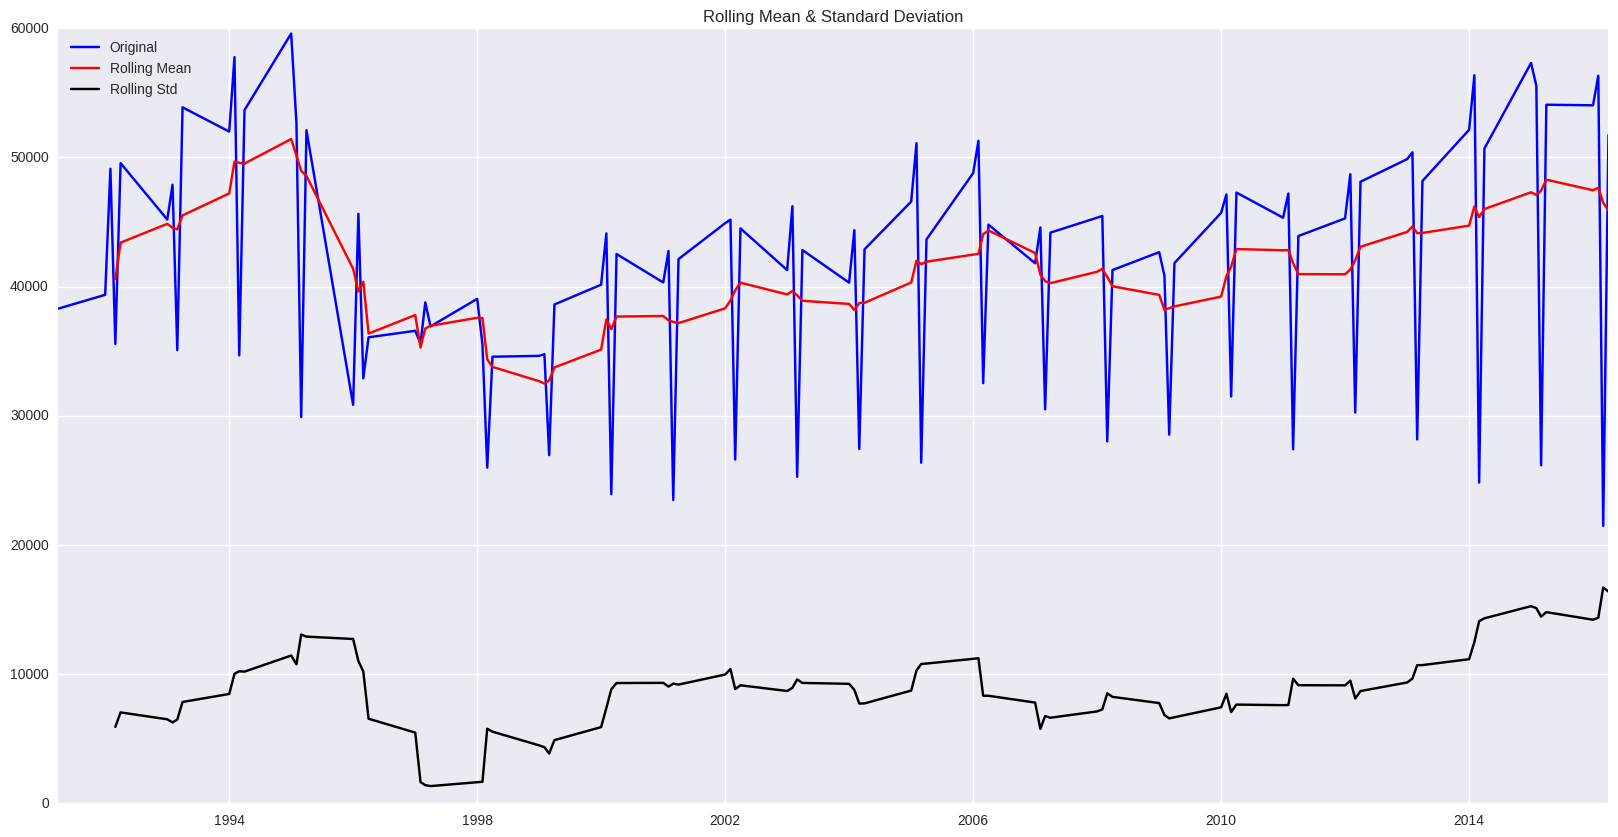

Results of Dickey-Fuller Test:
Test Statistic                 -1.835473
p-value                         0.362998
#Lags Used                      7.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [4]:
test_stationarity(df_cl['Cap_Diff'])

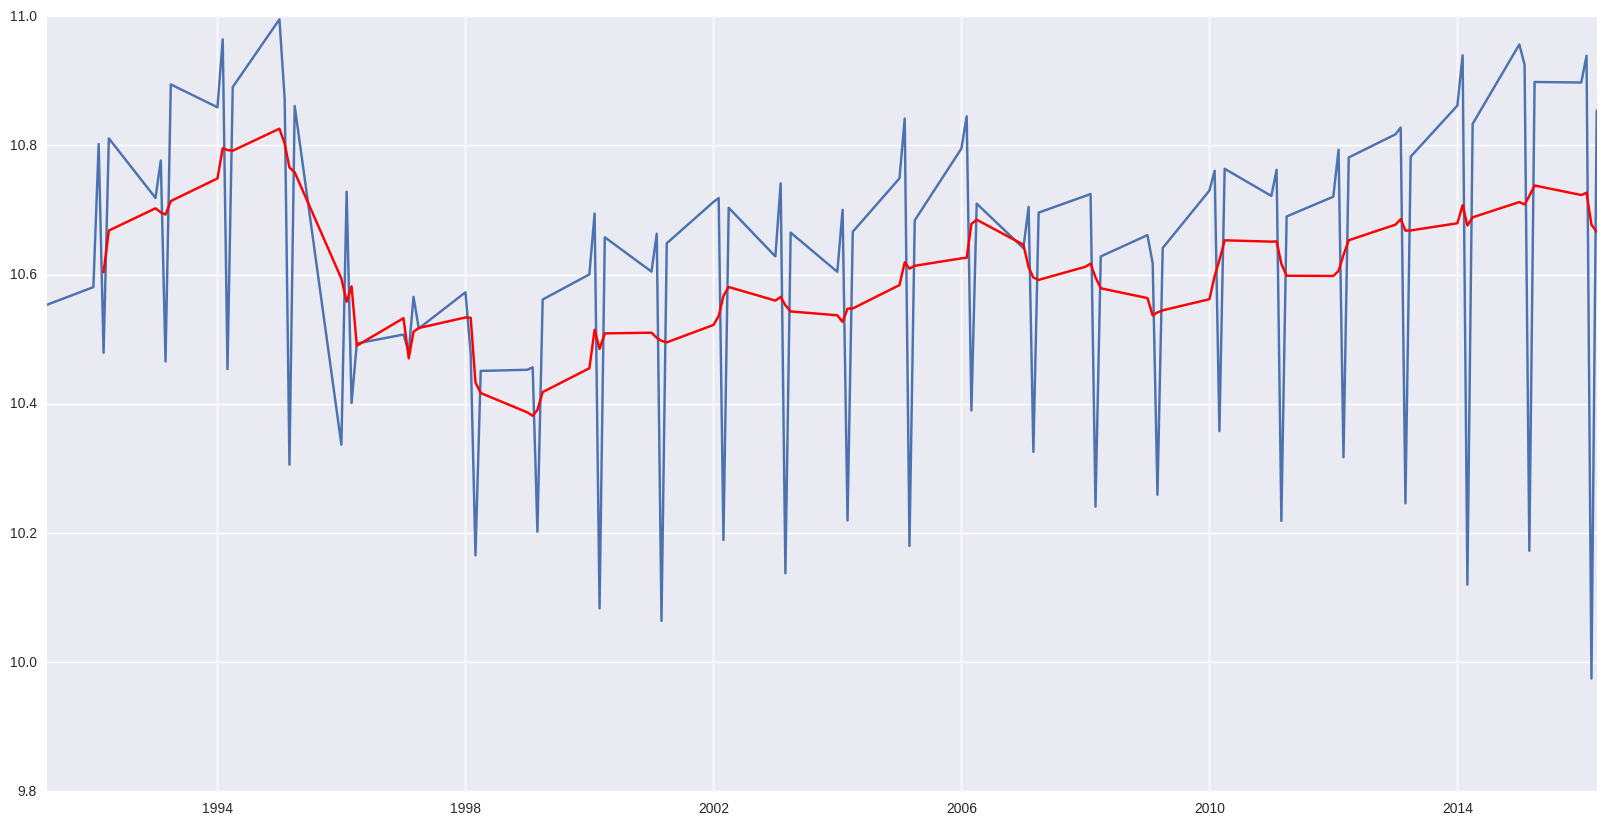

In [5]:
#Estimating and eliminating trend
ts_log = np.log(df_cl['Cap_Diff'])
moving_avg = pd.Series.rolling(ts_log, center=False,window=4).mean()
plt.figure(figsize=(20,10))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()


   ===Test stationarity using log moving average===



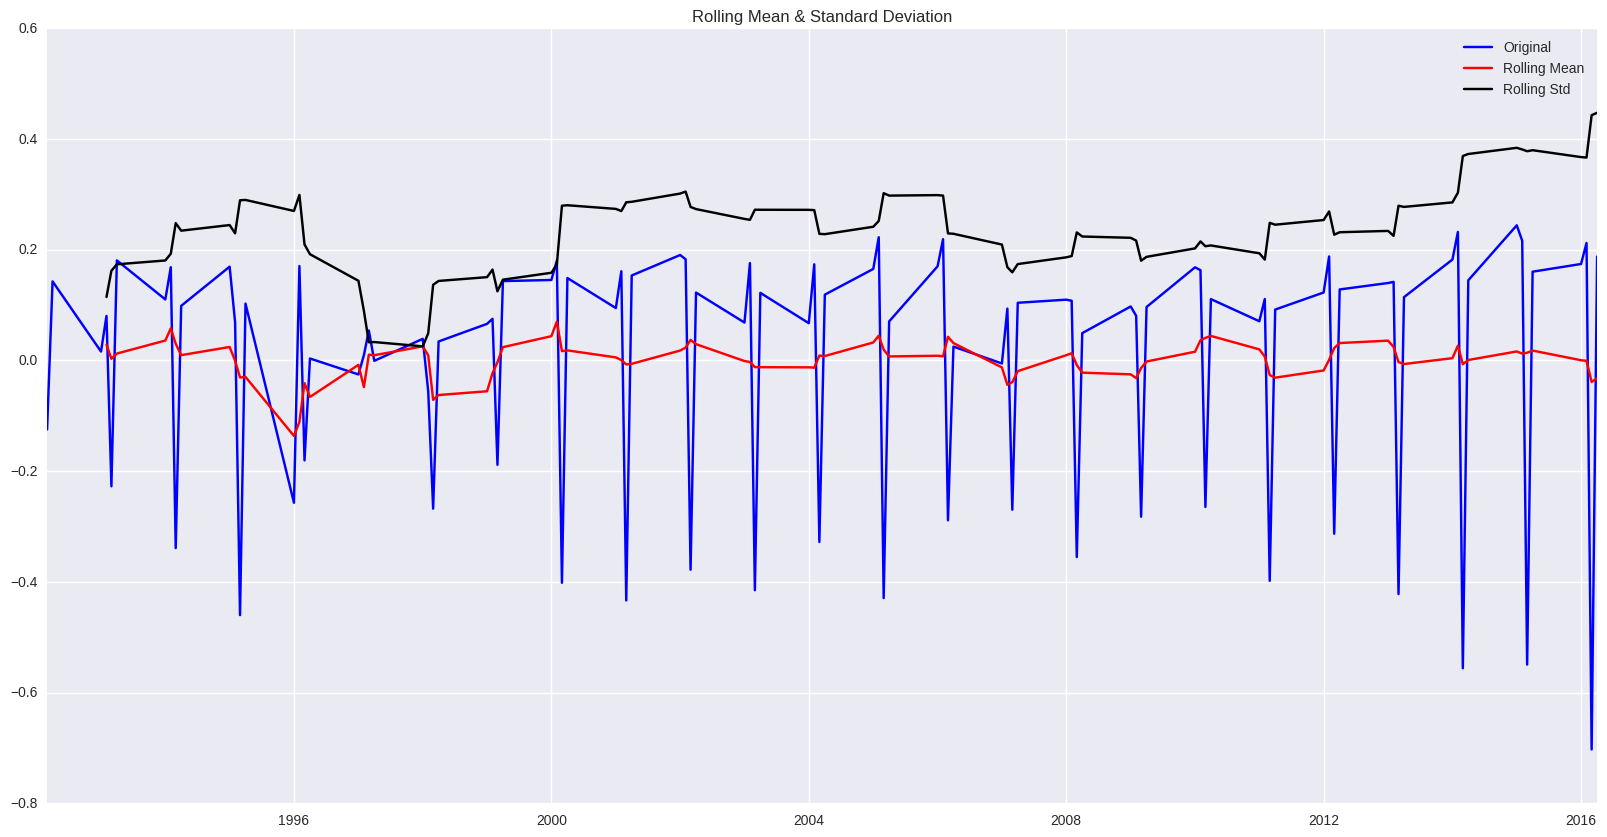

Results of Dickey-Fuller Test:
Test Statistic                 -4.010418
p-value                         0.001357
#Lags Used                      8.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [6]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(4)
ts_log_moving_avg_diff.dropna(inplace=True)
print("\n   ===Test stationarity using log moving average===\n")
test_stationarity(ts_log_moving_avg_diff)


   ===Use Exponentially Weighted Moving Average===



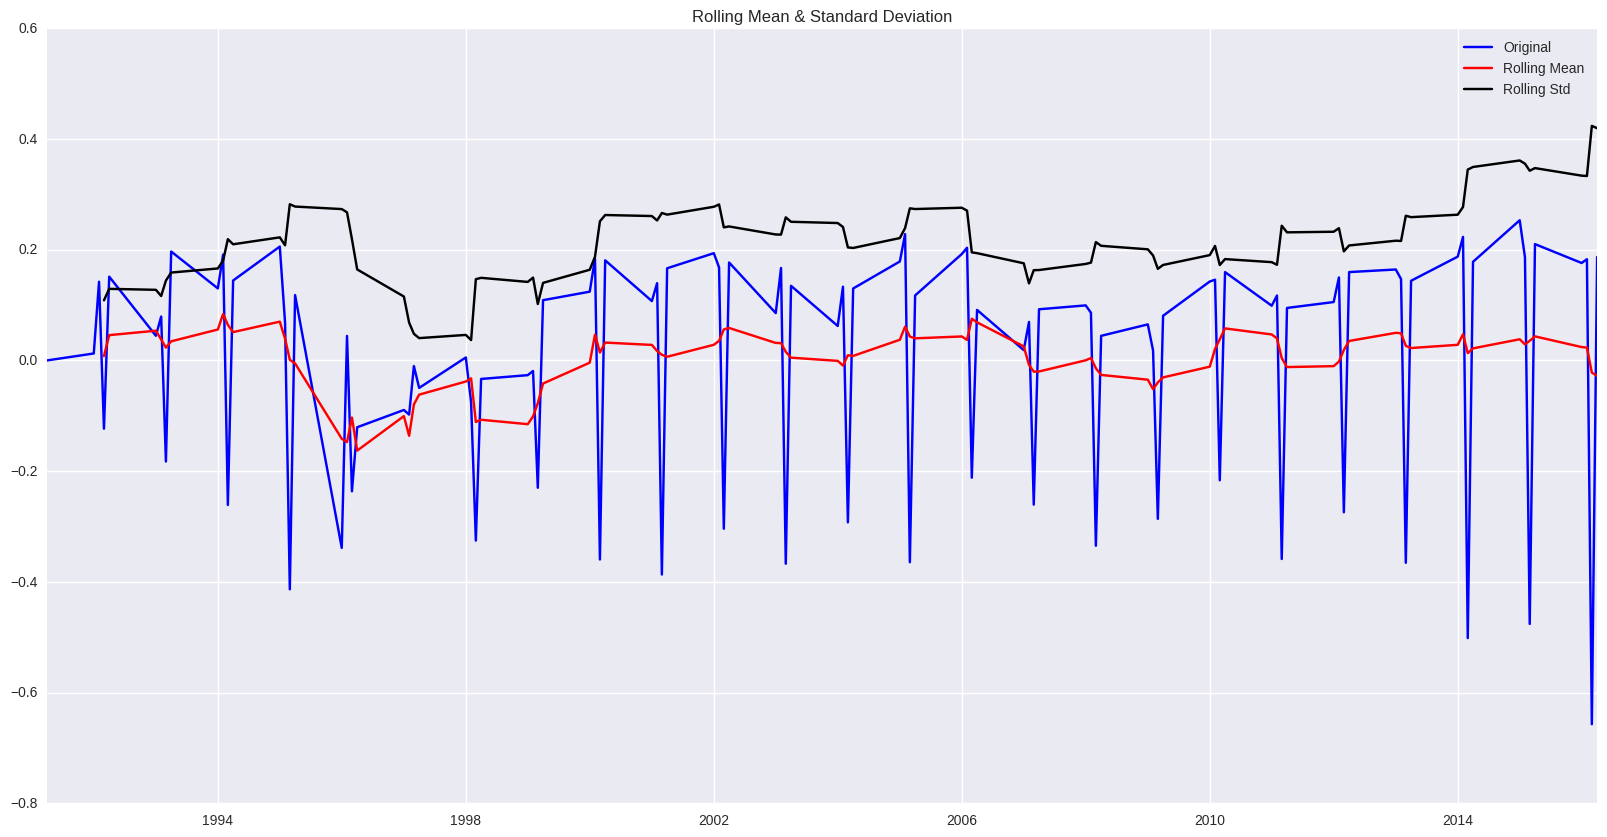

Results of Dickey-Fuller Test:
Test Statistic                 -2.412689
p-value                         0.138187
#Lags Used                      7.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [7]:
print("\n   ===Use Exponentially Weighted Moving Average===\n")
expwighted_avg = pd.Series.ewm(ts_log, ignore_na=False,min_periods=0,adjust=True,halflife=4).mean()
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)  


   ===Use Differencing Technique===



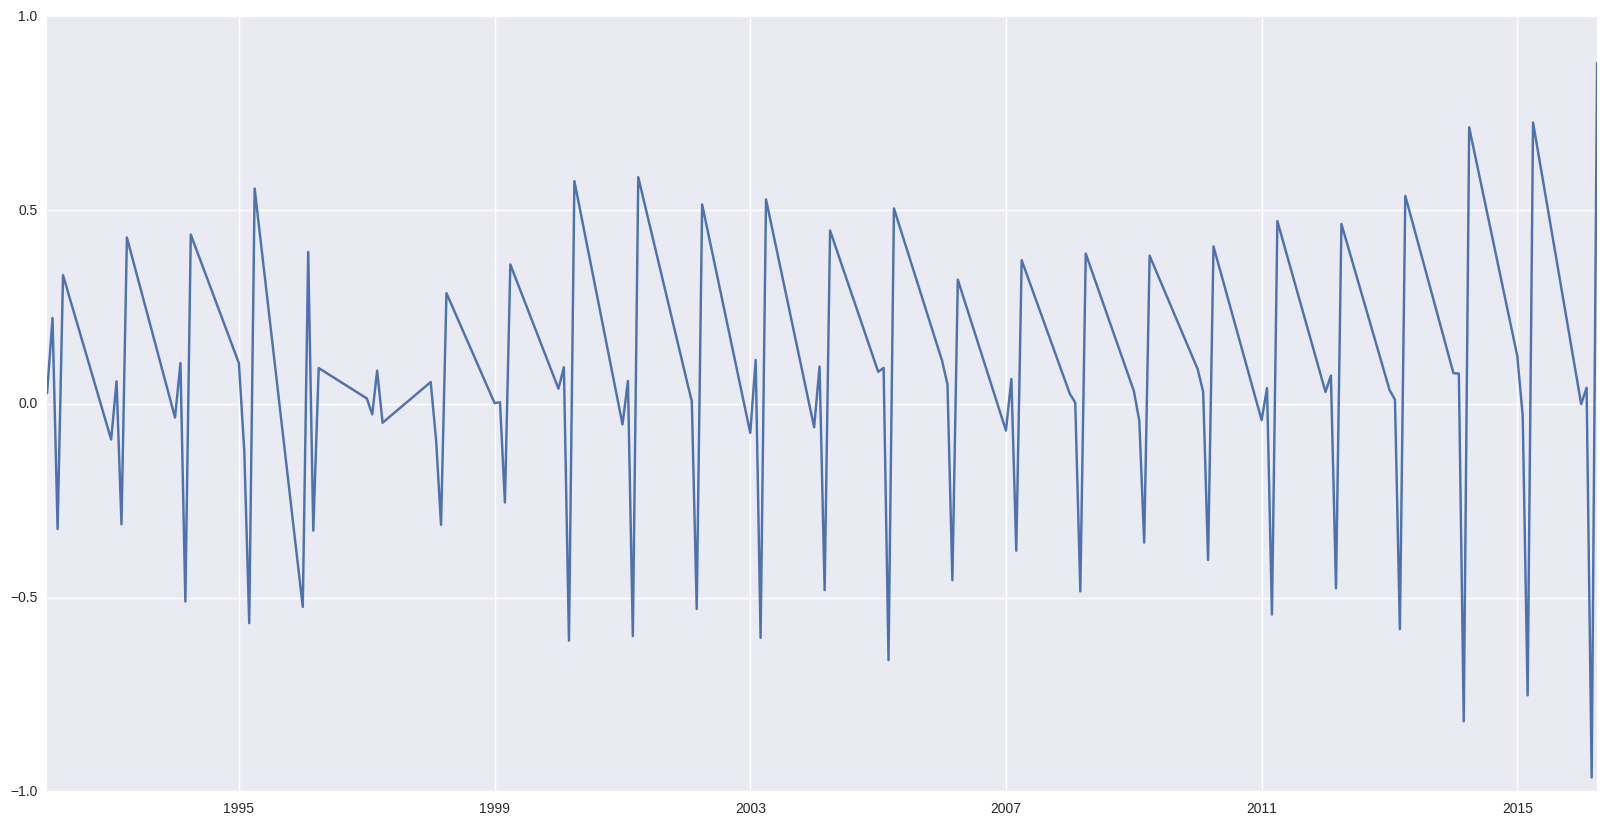

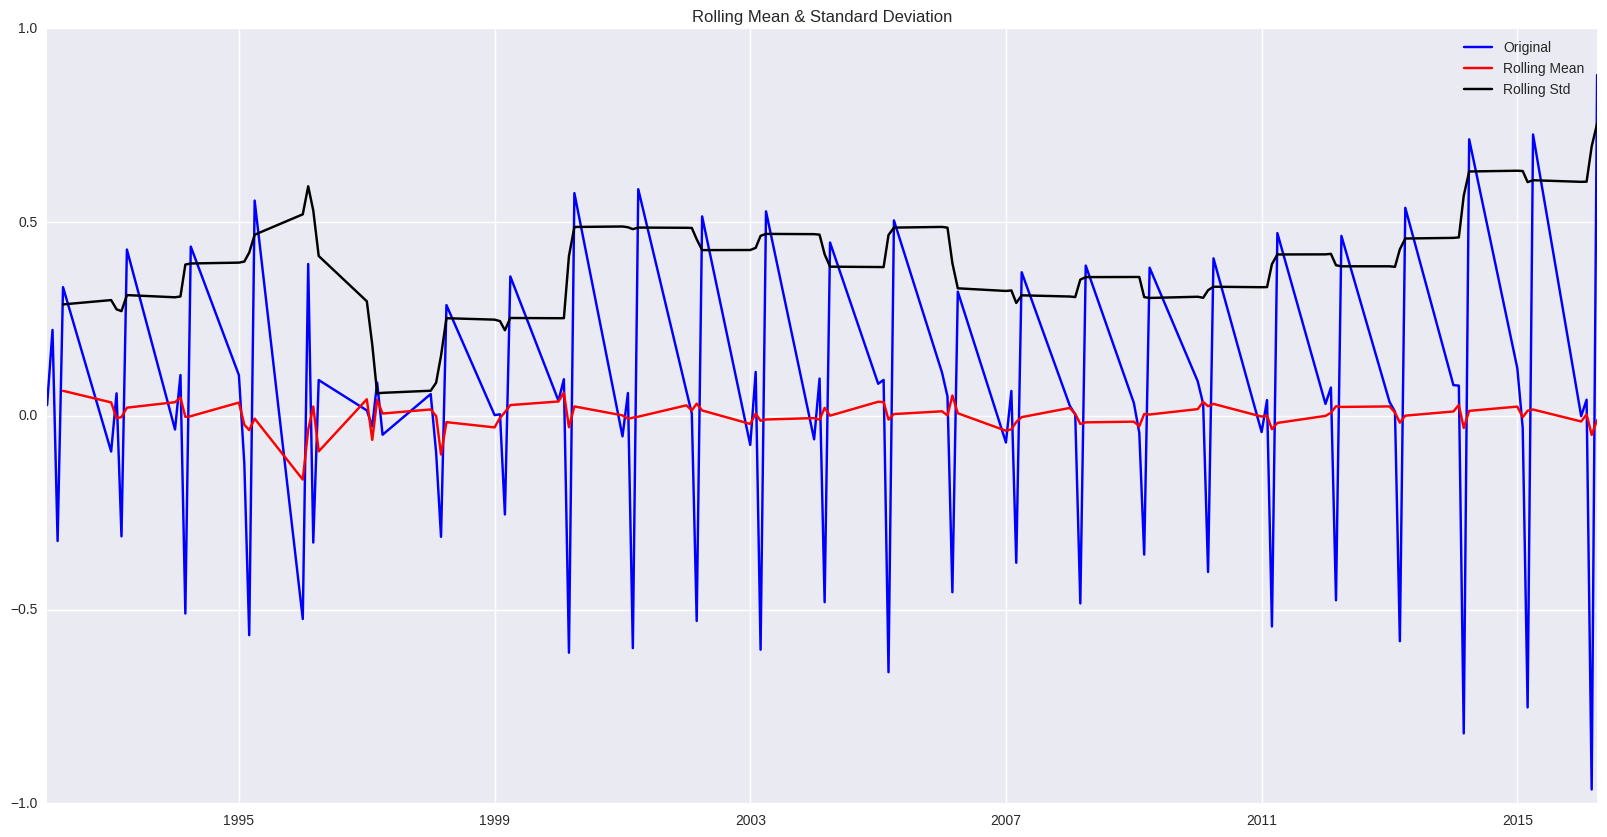

Results of Dickey-Fuller Test:
Test Statistic                 -4.976843
p-value                         0.000025
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [8]:
#Differencing
print("\n   ===Use Differencing Technique===\n")
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


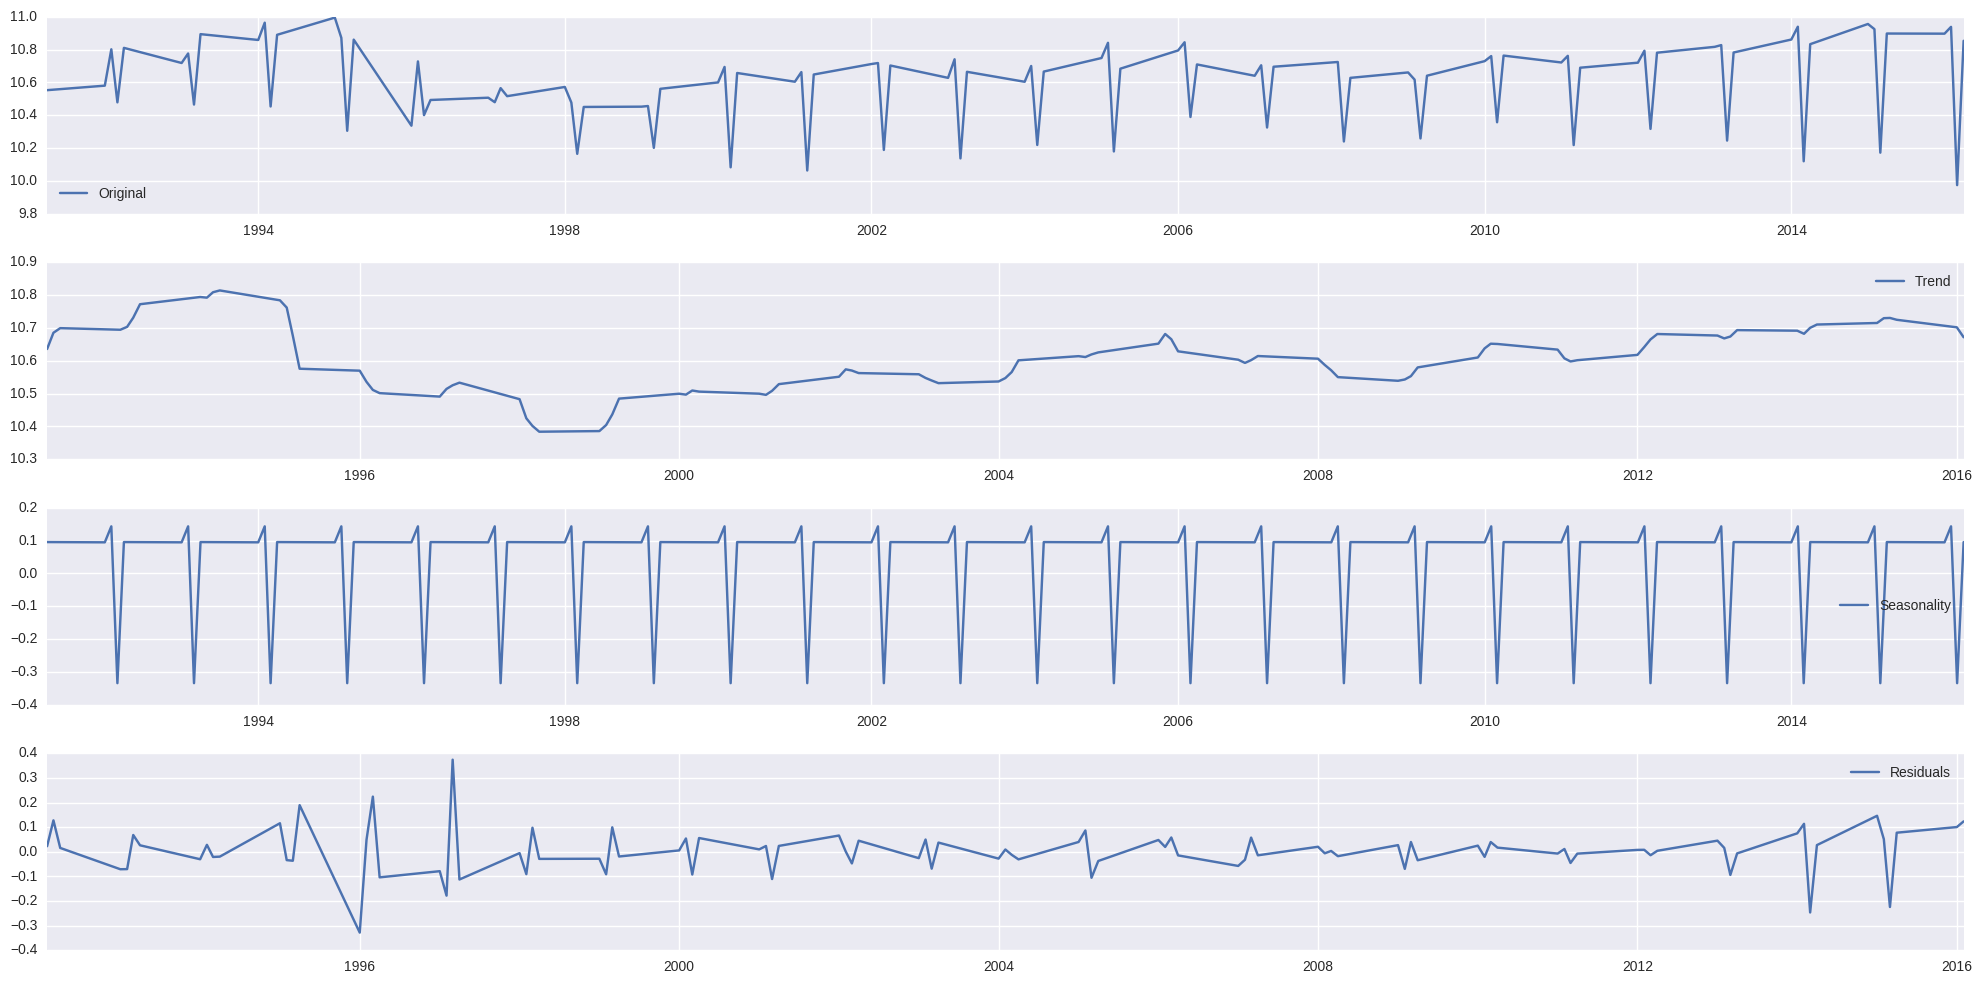

In [9]:
decomposition = seasonal_decompose(ts_log, freq=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


   ===Test Stationarity of Residuals===



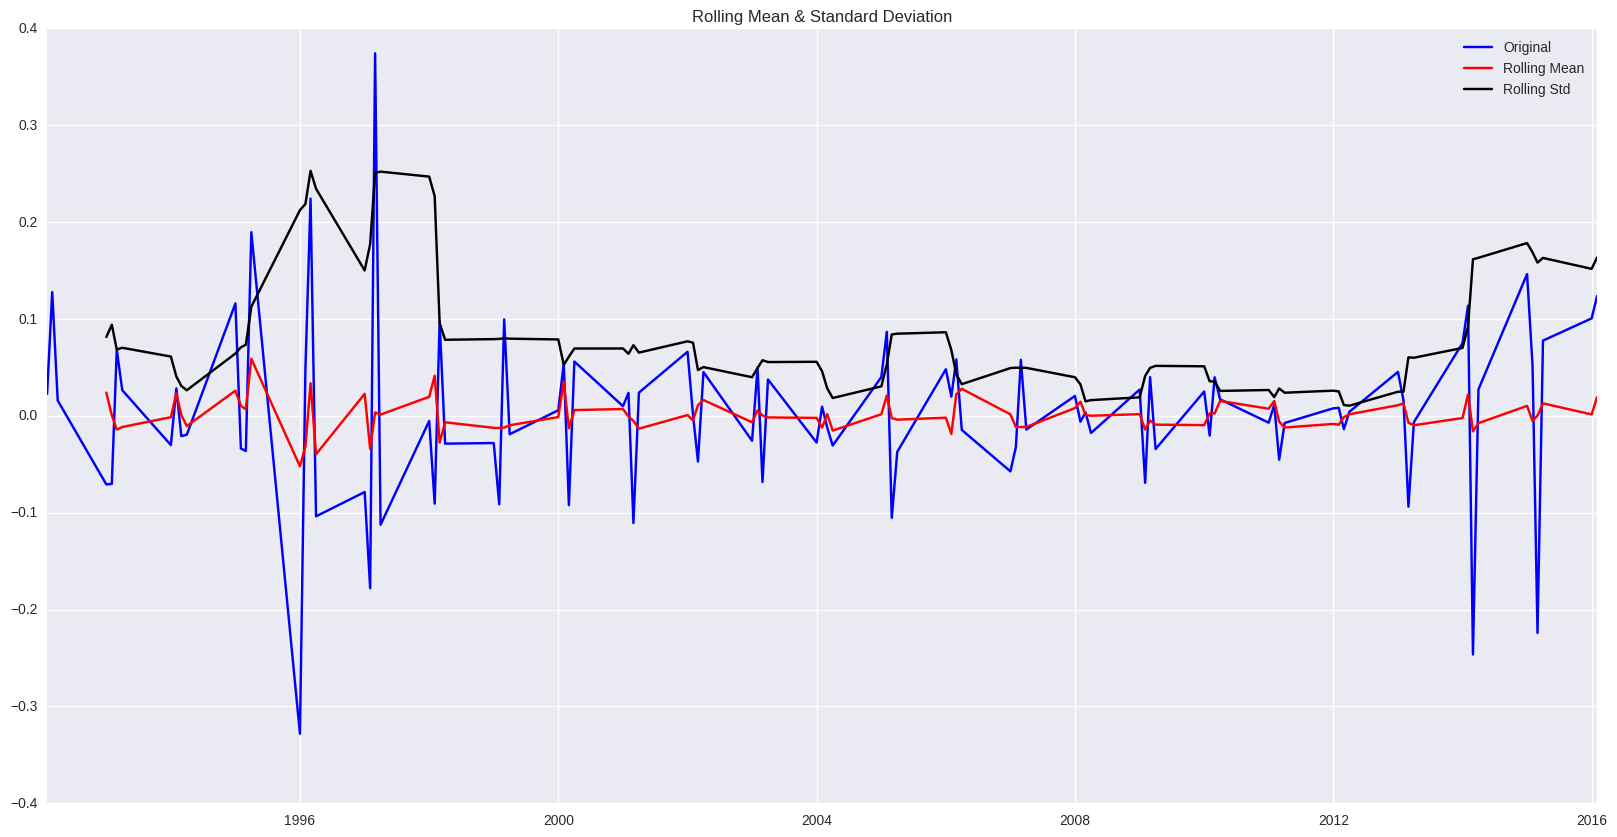

Results of Dickey-Fuller Test:
Test Statistic                 -5.309222
p-value                         0.000005
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [10]:
print("\n   ===Test Stationarity of Residuals===\n")
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

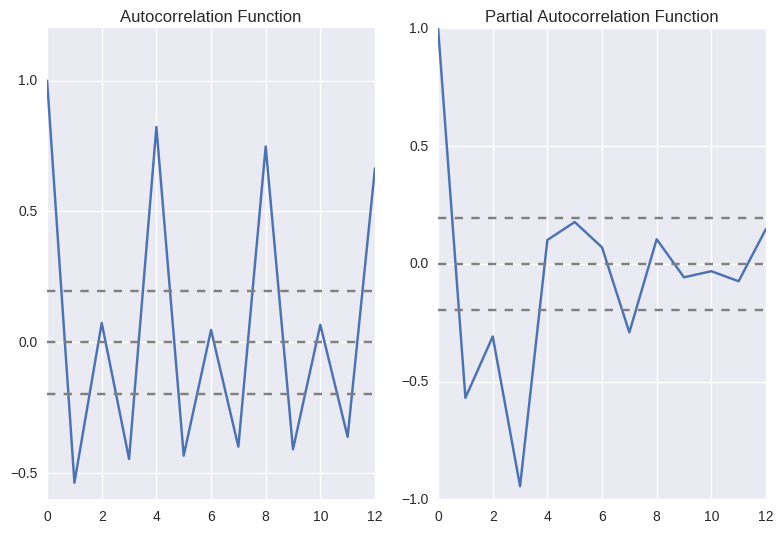

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

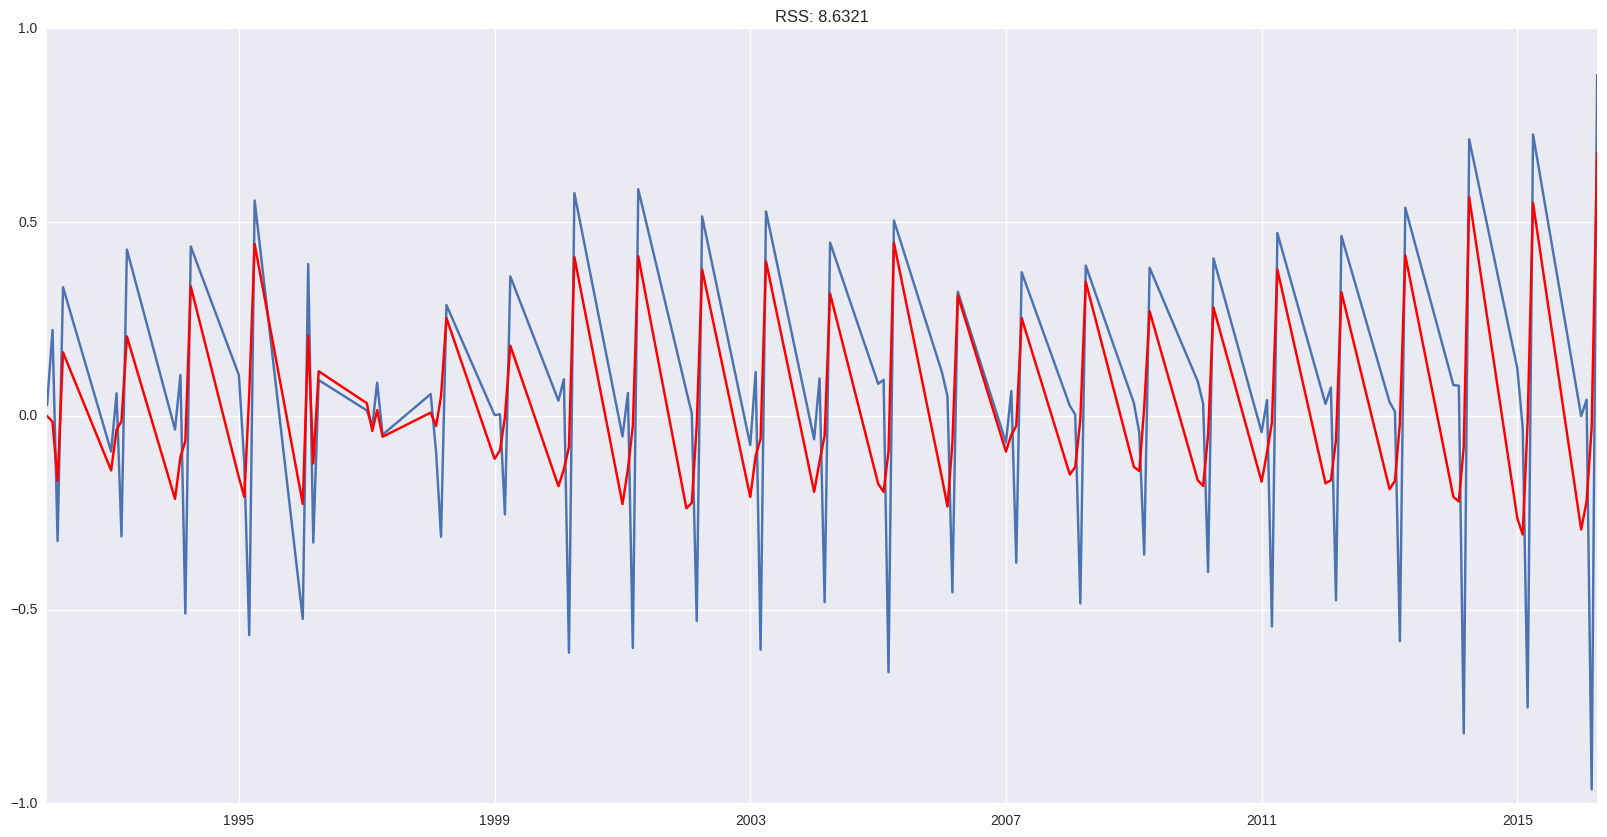

In [12]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

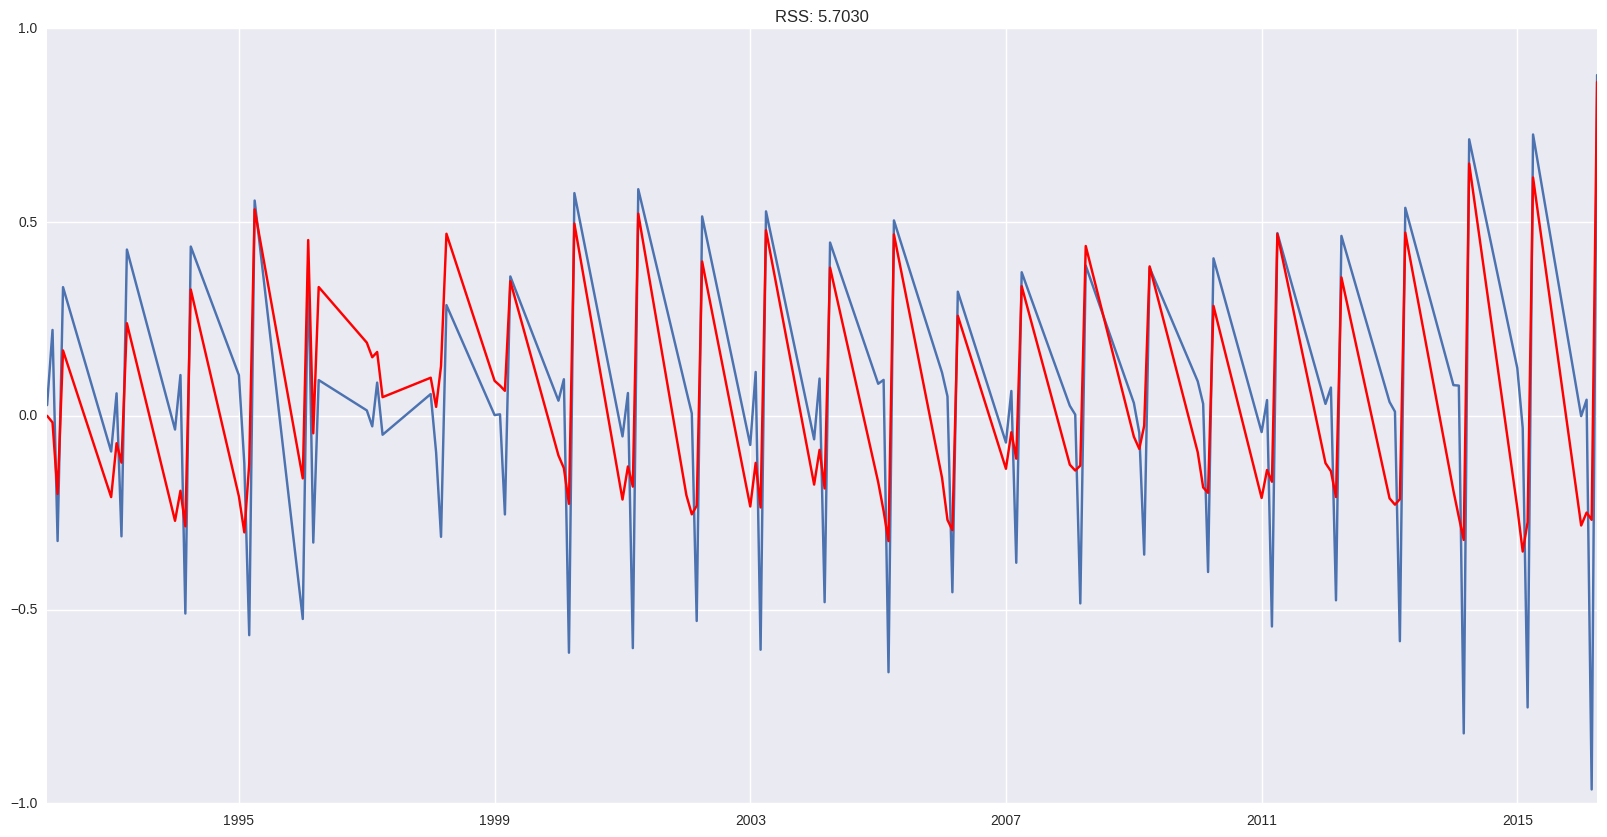

In [14]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/kevin/anaconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization fai

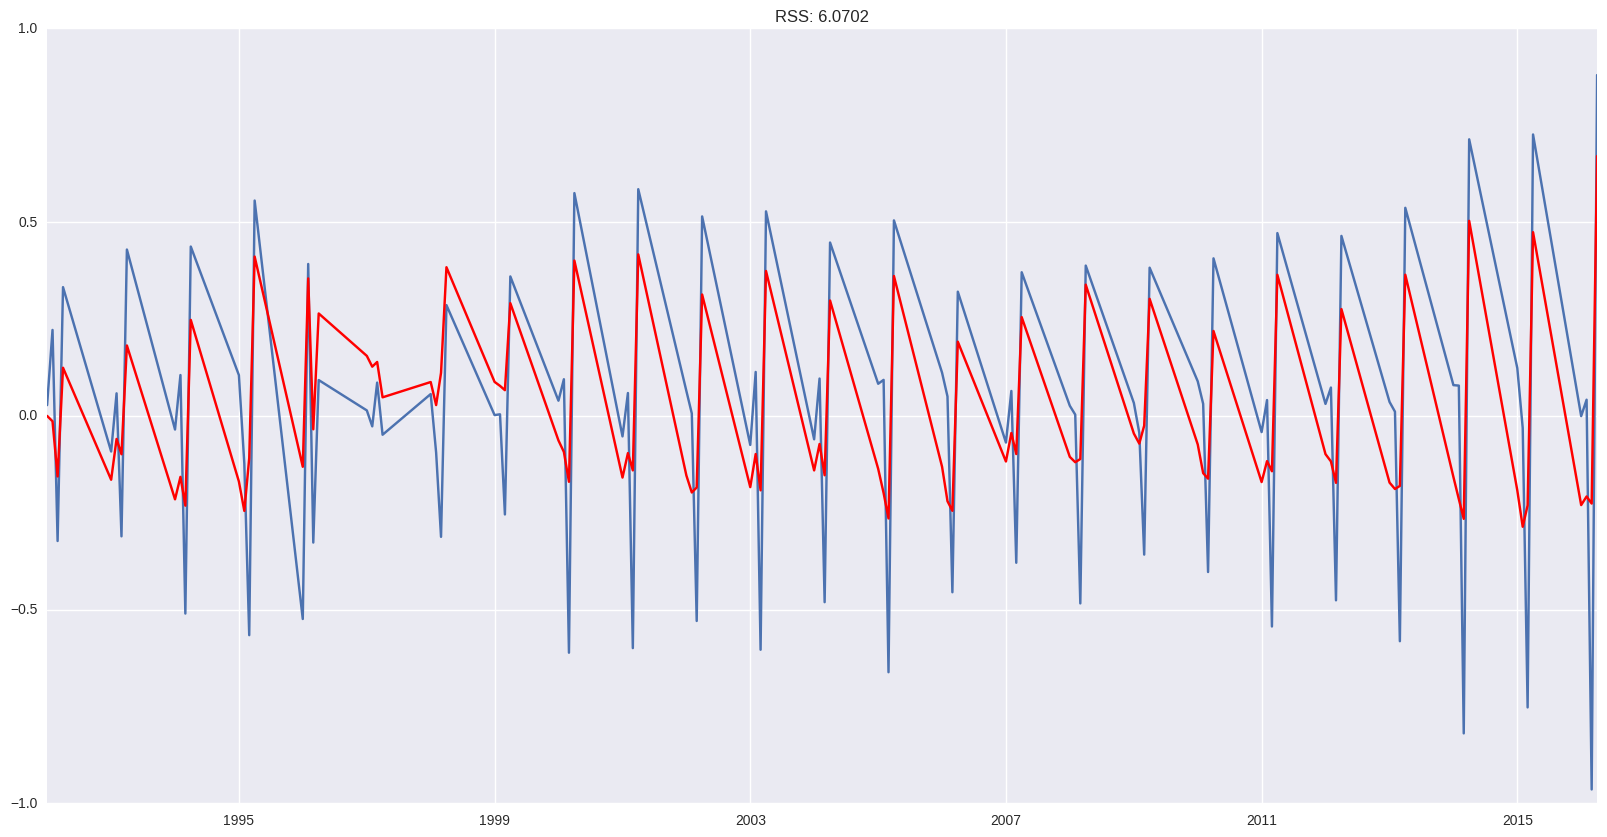

In [15]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [16]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Term_Date
1992-01-01   -0.000326
1992-02-01   -0.014195
1992-03-01   -0.156597
1992-04-01    0.123915
1993-01-01   -0.165104
dtype: float64


In [17]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Term_Date
1992-01-01   -0.000326
1992-02-01   -0.014522
1992-03-01   -0.171118
1992-04-01   -0.047204
1993-01-01   -0.212307
dtype: float64


In [18]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Term_Date
1991-04-01    10.553153
1992-01-01    10.552826
1992-02-01    10.538631
1992-03-01    10.382035
1992-04-01    10.505949
dtype: float64

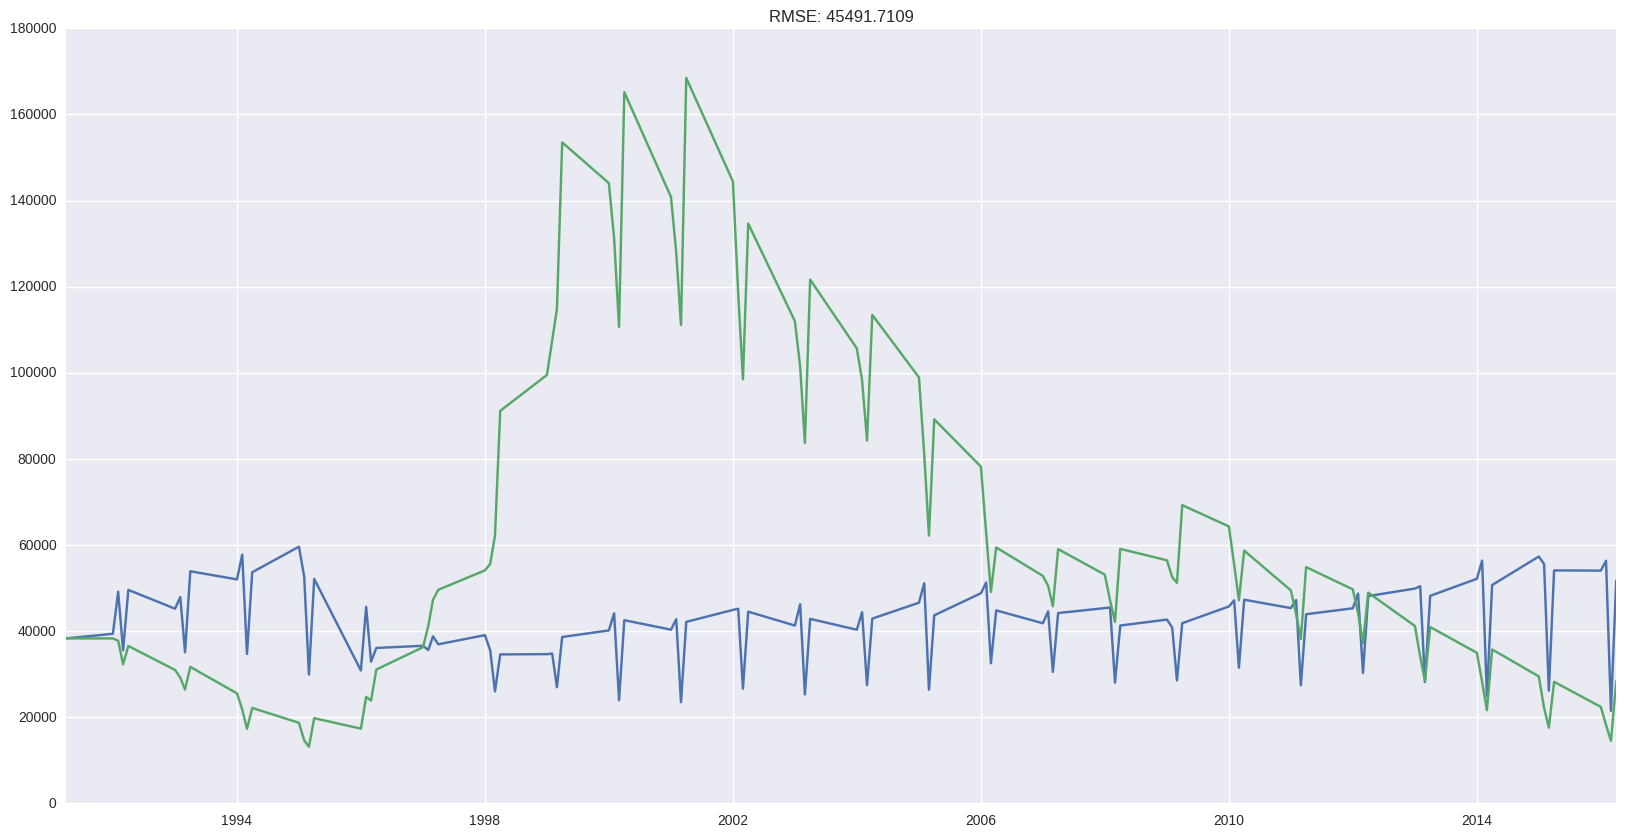

In [19]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(df_cl['Cap_Diff'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_cl['Cap_Diff'])**2)/len(df_cl['Cap_Diff'])))
plt.show()